In [ ]:
pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 16kB/s 
     |████████████████████████████████| 12.8MB 244kB/s 
     |████████████████████████████████| 7.6MB 9.6MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from os.path import exists

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

7.0.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/kt_sak_train.zip -d train
!unzip -q /content/gdrive/MyDrive/kt_sak_test.zip -d val

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Jan 25 21:36:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
unlabeler = LabelEncoder()
labels = [path.parent.name for path in train_files]
unlabeler.fit(labels)
with open('label_sak_smalla_encoder.pkl', 'wb') as le_dump_file:
        pickle.dump(unlabeler, le_dump_file)

In [ ]:
class KTDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, encoder):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = encoder

        if self.mode != 'test':
            self.labels = torch.FloatTensor([1 if path.parent.name=="САК" else 0 for path in self.files])
            

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            return x, label
        
    def _prepare_sample(self, image):
        image = image.crop((470, 0, 1449, 979))
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
import random

In [ ]:
TRAIN_DIR = Path('train/kt_sak_train')
train_files = list(TRAIN_DIR.rglob('*.jpg'))
random.shuffle(train_files)
print(train_files)

[PosixPath('train/kt_sak_train/САК/3D_MPR_-_Martyanova_O._L.\u200e_(68y)_-_08.10.2020_12_20_19_-__Head_1.0_0045.jpg'), PosixPath('train/kt_sak_train/САК/3D_MPR_-_TASHIROV__A.N.\u200e_(54y)_-_10.08.2020_13_22_57_-_SFT_0.625_0112.jpg'), PosixPath('train/kt_sak_train/САК отсутствует/3D_MPR_-_PURTOV_S_G\u200e_(58y)_-_18.10.2020_10_34_25_-_Head__1.5__J30s_0130.jpg'), PosixPath('train/kt_sak_train/САК/3D_MPR_-_MASYUTIN_N_A\u200e_(62y)_-_30.09.2020_18_09_14_-__Head_0.5_0068.jpg'), PosixPath('train/kt_sak_train/САК отсутствует/3D_MPR_-_RIBOLOVLEVA__L_A\u200e_(75y)_-_05.08.2020_22_03_27_-_Head__1.5__J30s_0055.jpg'), PosixPath('train/kt_sak_train/САК отсутствует/3D_MPR_-_Markshteder_M.V.\u200e_(55y)_-_27.09.2020_17_21_48_-_brain_soft_0144.jpg'), PosixPath('train/kt_sak_train/САК отсутствует/3D_MPR_-_YUMAKOV_V_I\u200e_(62y)_-_22.10.2020_19_39_04_-__Head_0.5_0130.jpg'), PosixPath('train/kt_sak_train/САК отсутствует/3D_MPR_-_DUBOVEDSKIY_V_R\u200e_(71y)_-_21.09.2020_23_37_49_-_Head__1.5__J30s_0071.j

In [ ]:
VAL_DIR = Path('val/kt_sak_test')
val_files=list(VAL_DIR.rglob('*.jpg'))
random.shuffle(val_files)
print(val_files)

[PosixPath('val/kt_sak_test/САК отсутствует/3D_MPR_-_BARYISHEV_M.T\u200e_(73y)_-_09.08.2020_9_17_27_-_soft_0015.jpg'), PosixPath('val/kt_sak_test/САК отсутствует/3D_MPR_-_BEZNOSOV_V_F\u200e_(69y)_-_15.10.2020_10_47_44_-_Head__1.5__J30s_0085.jpg'), PosixPath('val/kt_sak_test/САК отсутствует/3D_MPR_-_BARYISHEV_M.T\u200e_(73y)_-_09.08.2020_9_17_27_-_soft_0005.jpg'), PosixPath('val/kt_sak_test/САК отсутствует/3D_MPR_-_SBRODOV__M_F\u200e_(48y)_-_09.10.2020_13_26_07_-_Hel_1.25mm_0006.jpg'), PosixPath('val/kt_sak_test/САК отсутствует/3D_MPR_-_MITYUKHLYAEV_B_I\u200e_(81y)_-_01.10.2020_12_28_36_-__Head_0.5_0087.jpg'), PosixPath('val/kt_sak_test/САК отсутствует/3D_MPR_-_KABIEVA_A\u200e_(81y)_-_02.10.2020_20_46_25_-__Head_0.5_0099.jpg'), PosixPath('val/kt_sak_test/САК отсутствует/3D_MPR_-_GULAKOVA_G_T\u200e_(65y)_-_23.09.2020_11_13_04_-_Head__1.0__J30s_0108.jpg'), PosixPath('val/kt_sak_test/САК/3D_MPR_-_ANTIPOVA_V.N.\u200e_(75y)_-_09.10.2020_7_24_01_-_SFT_0.625_0058.jpg'), PosixPath('val/kt_sak_t

In [ ]:
val_dataset = KTDataset(val_files, mode='val', encoder=unlabeler)
print(len(val_dataset))

351


In [ ]:
train_dataset = KTDataset(train_files, mode = 'train', encoder=unlabeler)

In [ ]:
print(len(train_files))

10365


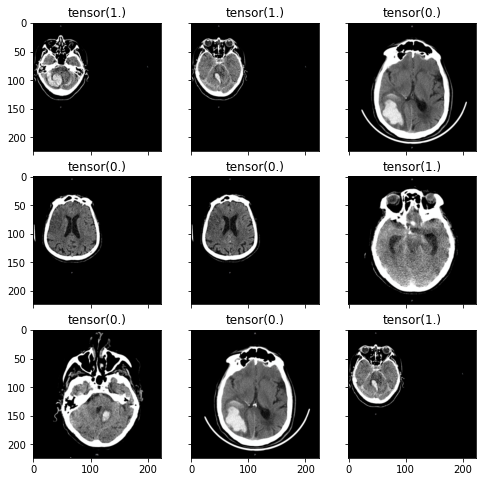

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,260))
    im_val, label = val_dataset[random_characters]
    img_label = label
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
import torch.nn as nn

class SmallCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )

        self.out = nn.Linear(32, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # print(x.shape)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits


In [ ]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [ ]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [ ]:
def macro_soft_f1(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

In [ ]:
from torchvision import datasets, models, transforms

num_classes=1
torch.manual_seed(42)
np.random.seed(42)

base_model=SmallCnn(num_classes)

base_model=base_model.to(DEVICE)

# loss_fn = f1_loss

# optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-2)

# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        # print(inputs.shape)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        # print(outputs.shape)
        try:
            outputs=torch.reshape(outputs, (64,))
        except:
            outputs=torch.reshape(outputs, (61,))
        # print(outputs.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 0)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    # all_f1=0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            try:
                outputs=torch.reshape(outputs, (64,))
            except:
                outputs=torch.reshape(outputs, (31,))
            
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 0)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        # f1_metr=f1_score(labels.cpu(), preds.cpu(), average=None)
        # all_f1+=f1_metr
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    # f1_result=all_f1/processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.BCEWithLogitsLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            torch.save(model.state_dict(), "gdrive/MyDrive/KT_binary_sak_smalla_"+str(epoch+1)+".pth")
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
print(base_model)

SmallCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
history = train(train_dataset, val_dataset, model=base_model, epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 0.40869949862281885


epoch:   3%|▎         | 1/30 [04:09<2:00:34, 249.48s/it]


Epoch 001 train_loss: 0.4087     val_loss 0.9195 train_acc 0.0119 val_acc 0.0883
loss 0.2840057557898906


epoch:   7%|▋         | 2/30 [08:19<1:56:26, 249.52s/it]


Epoch 002 train_loss: 0.2840     val_loss 2.2337 train_acc 0.0123 val_acc 0.0000
loss 0.19272946083942474


epoch:  10%|█         | 3/30 [12:28<1:52:18, 249.58s/it]


Epoch 003 train_loss: 0.1927     val_loss 2.9196 train_acc 0.0366 val_acc 0.0000
loss 0.148863639826655


epoch:  13%|█▎        | 4/30 [16:37<1:48:02, 249.35s/it]


Epoch 004 train_loss: 0.1489     val_loss 4.4981 train_acc 0.0402 val_acc 0.0000
loss 0.1195300067514828


epoch:  17%|█▋        | 5/30 [20:45<1:43:44, 248.98s/it]


Epoch 005 train_loss: 0.1195     val_loss 4.9248 train_acc 0.1063 val_acc 0.0000
loss 0.10137683777879875


epoch:  20%|██        | 6/30 [24:54<1:39:31, 248.83s/it]


Epoch 006 train_loss: 0.1014     val_loss 4.9851 train_acc 0.1093 val_acc 0.0000
loss 0.08649857961759151


epoch:  23%|██▎       | 7/30 [29:02<1:35:21, 248.78s/it]


Epoch 007 train_loss: 0.0865     val_loss 5.4486 train_acc 0.1327 val_acc 0.0000
loss 0.078770388639094


epoch:  27%|██▋       | 8/30 [33:08<1:30:52, 247.82s/it]


Epoch 008 train_loss: 0.0788     val_loss 5.3235 train_acc 0.1300 val_acc 0.1823
loss 0.06886295317683425


epoch:  30%|███       | 9/30 [37:12<1:26:20, 246.67s/it]


Epoch 009 train_loss: 0.0689     val_loss 7.4344 train_acc 0.0980 val_acc 0.0000
loss 0.05925107688948088


epoch:  33%|███▎      | 10/30 [41:16<1:21:54, 245.75s/it]


Epoch 010 train_loss: 0.0593     val_loss 6.5475 train_acc 0.1239 val_acc 0.1823
loss 0.05173473057165936


epoch:  37%|███▋      | 11/30 [45:19<1:17:37, 245.15s/it]


Epoch 011 train_loss: 0.0517     val_loss 7.1553 train_acc 0.1238 val_acc 0.0000
loss 0.04794316063223975


epoch:  40%|████      | 12/30 [49:23<1:13:24, 244.68s/it]


Epoch 012 train_loss: 0.0479     val_loss 7.6908 train_acc 0.1655 val_acc 0.0000
loss 0.044732960013091363


epoch:  43%|████▎     | 13/30 [53:27<1:09:14, 244.38s/it]


Epoch 013 train_loss: 0.0447     val_loss 7.9280 train_acc 0.1258 val_acc 0.0000
loss 0.04084608235683524


epoch:  47%|████▋     | 14/30 [57:30<1:05:06, 244.16s/it]


Epoch 014 train_loss: 0.0408     val_loss 7.8341 train_acc 0.1449 val_acc 0.1823
loss 0.04132078442735138


epoch:  50%|█████     | 15/30 [1:01:34<1:00:59, 243.97s/it]


Epoch 015 train_loss: 0.0413     val_loss 8.6119 train_acc 0.1162 val_acc 0.0000
loss 0.04344691905119801


epoch:  53%|█████▎    | 16/30 [1:05:37<56:54, 243.87s/it]


Epoch 016 train_loss: 0.0434     val_loss 8.4451 train_acc 0.1129 val_acc 0.1823
loss 0.0311986985814511


epoch:  57%|█████▋    | 17/30 [1:09:40<52:46, 243.60s/it]


Epoch 017 train_loss: 0.0312     val_loss 8.2064 train_acc 0.1131 val_acc 0.1823
loss 0.030824748469805062


epoch:  60%|██████    | 18/30 [1:13:44<48:42, 243.55s/it]


Epoch 018 train_loss: 0.0308     val_loss 8.8116 train_acc 0.1381 val_acc 0.1823
loss 0.026183234645234348


epoch:  63%|██████▎   | 19/30 [1:17:49<44:43, 243.99s/it]


Epoch 019 train_loss: 0.0262     val_loss 9.0514 train_acc 0.1524 val_acc 0.0000
loss 0.02565934175757527


epoch:  67%|██████▋   | 20/30 [1:21:54<40:42, 244.29s/it]


Epoch 020 train_loss: 0.0257     val_loss 11.5028 train_acc 0.1318 val_acc 0.1823
loss 0.024040256157064576


epoch:  70%|███████   | 21/30 [1:25:59<36:41, 244.62s/it]


Epoch 021 train_loss: 0.0240     val_loss 9.6525 train_acc 0.1319 val_acc 0.1823
loss 0.020748125962298445


epoch:  73%|███████▎  | 22/30 [1:30:05<32:38, 244.86s/it]


Epoch 022 train_loss: 0.0207     val_loss 9.7245 train_acc 0.1519 val_acc 0.0000
loss 0.021961224176712042


epoch:  77%|███████▋  | 23/30 [1:34:10<28:35, 245.03s/it]


Epoch 023 train_loss: 0.0220     val_loss 10.6531 train_acc 0.1303 val_acc 0.0000
loss 0.016342650836776607


epoch:  80%|████████  | 24/30 [1:38:15<24:29, 244.99s/it]


Epoch 024 train_loss: 0.0163     val_loss 11.3884 train_acc 0.1472 val_acc 0.1823
loss 0.01636962270066753


epoch:  83%|████████▎ | 25/30 [1:42:21<20:26, 245.33s/it]


Epoch 025 train_loss: 0.0164     val_loss 11.6612 train_acc 0.1694 val_acc 0.1823
loss 0.016359953271037304


epoch:  87%|████████▋ | 26/30 [1:46:31<16:27, 246.76s/it]


Epoch 026 train_loss: 0.0164     val_loss 12.4876 train_acc 0.1638 val_acc 0.0000
loss 0.017376403332842013


epoch:  90%|█████████ | 27/30 [1:50:41<12:23, 247.77s/it]


Epoch 027 train_loss: 0.0174     val_loss 10.8303 train_acc 0.0512 val_acc 0.0000
loss 0.011186629111595089


epoch:  93%|█████████▎| 28/30 [1:54:50<08:15, 247.98s/it]


Epoch 028 train_loss: 0.0112     val_loss 14.7537 train_acc 0.0113 val_acc 0.0000
loss 0.01516883406323039


epoch:  97%|█████████▋| 29/30 [1:58:58<04:08, 248.07s/it]


Epoch 029 train_loss: 0.0152     val_loss 10.3423 train_acc 0.0250 val_acc 0.1823
loss 0.002277162783607136


epoch: 100%|██████████| 30/30 [2:03:04<00:00, 246.16s/it]


Epoch 030 train_loss: 0.0023     val_loss 11.7074 train_acc 0.0139 val_acc 0.0000


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

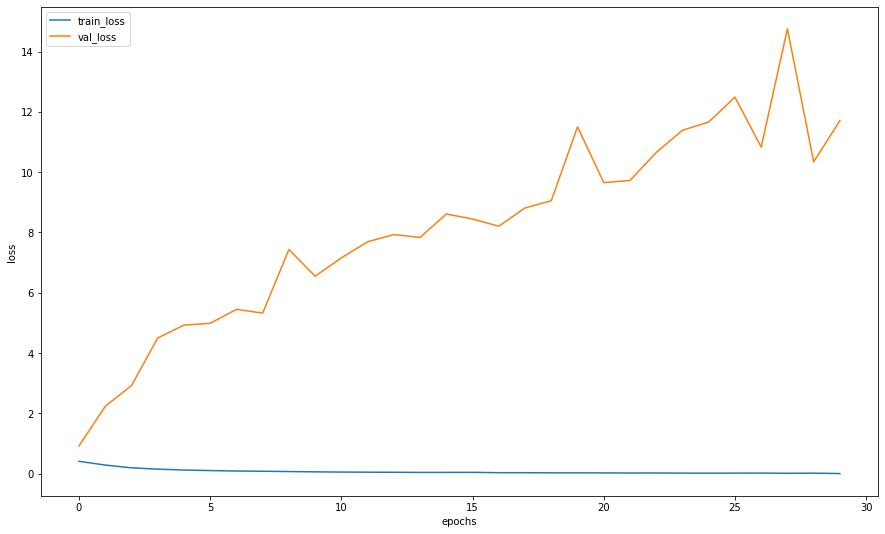

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,260))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(base_model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,260,100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

In [ ]:
# actual_labels=[label_encoder.classes_[i] for i in actual_labels]
print(actual_labels)
print(y_pred)

[tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), ten

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)


array([0.82352941, 0.        ])

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    print(logits)
    probs = nn.functional.sigmoid(torch.cat(logits)).numpy()
    probs = [1 if i>=0.5 else 0 for i in probs]
    return probs

idxs = list(map(int, np.random.uniform(0,260,100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)
print(probs_ims)

actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score

print(actual_labels)
print(probs_ims)
print(f1_score(actual_labels, probs_ims, average=None))

nice=0
for i in range(100):
    if actual_labels[i]==probs_ims[i]:
      nice+=1
print(nice)

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    print(logits)
    probs = nn.functional.sigmoid(torch.cat(logits)).numpy()
    probs = [1 if i>=0.5 else 0 for i in probs]
    return probs

idxs = list(map(int, np.random.uniform(0,260,100)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)
print(probs_ims)

actual_labels = [val_dataset[id][1] for id in idxs]
from sklearn.metrics import f1_score

print(actual_labels)
print(probs_ims)
print(f1_score(actual_labels, probs_ims, average=None))

nice=0
for i in range(100):
    if actual_labels[i]==probs_ims[i]:
      nice+=1
print(nice)

[tensor([[-95.3840]]), tensor([[-36.8586]]), tensor([[-10.6741]]), tensor([[-19.5452]]), tensor([[-26.0555]]), tensor([[-16.3963]]), tensor([[-71.0667]]), tensor([[-103.8245]]), tensor([[-14.0674]]), tensor([[-28.3481]]), tensor([[-98.1778]]), tensor([[-24.8568]]), tensor([[-10.0535]]), tensor([[-93.6280]]), tensor([[-10.2564]]), tensor([[-10.1925]]), tensor([[-97.5922]]), tensor([[-20.8600]]), tensor([[-92.2220]]), tensor([[-11.2708]]), tensor([[-20.8600]]), tensor([[-36.2975]]), tensor([[-79.8990]]), tensor([[-103.8245]]), tensor([[-38.5582]]), tensor([[-8.7541]]), tensor([[-10.1466]]), tensor([[-5.3906]]), tensor([[-10.6741]]), tensor([[-31.1056]]), tensor([[-102.0627]]), tensor([[-86.0320]]), tensor([[-16.0167]]), tensor([[-18.3309]]), tensor([[-15.9229]]), tensor([[-10.4099]]), tensor([[-62.3587]]), tensor([[-13.6999]]), tensor([[-20.1113]]), tensor([[-17.7496]]), tensor([[-26.0555]]), tensor([[-14.1008]]), tensor([[-32.6073]]), tensor([[-28.2264]]), tensor([[-18.5866]]), tensor([

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), ten

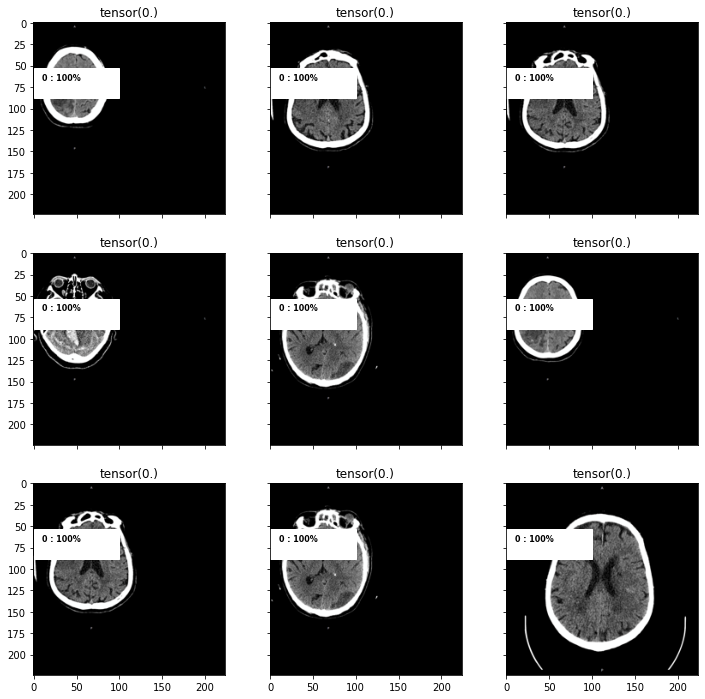

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,260))
    im_val, label = val_dataset[random_characters]
    img_label = label

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = y_pred
    predicted_label = predicted_label
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
torch.save(base_model.state_dict(), "gdrive/MyDrive/KT_binary_sak_smalla_v2_last.pth")

In [ ]:
def predict_picture(file_name):
    TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

    test_files = list(TEST_DIR.rglob(file_name))

    test_dataset = KTDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(base_model, test_loader)
    print(probs)
    predicted_proba = np.max(probs)*100
    for i in range(len(probs[0])):
      print(probs[0][i]*100, label_encoder.classes_[i])
    y_pred = np.argmax(probs)
    predicted_label = label_encoder.classes_[y_pred]
    return predicted_label, predicted_proba

  

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
print(predict_picture("10.jpg"))

[[2.3849365e-05 7.8634754e-02 9.4841748e-02 3.5471048e-02 3.6185865e-09
  9.6606191e-06 1.3273510e-01 2.4622777e-03 3.6915779e-08 1.2144416e-04
  3.2435180e-04 4.2660564e-02 6.1262834e-01 8.6691303e-05]]
0.0023849364879424684 ВЖК
7.8634753823280334 ВМГ 1
9.484174847602844 ВМГ 2
3.5471048206090927 ВМГ_ВЖК
3.6185865415205853e-07 ВМГ_ВЖК_САК
0.0009660619070928078 ВМГ_ВЖК_ишем
13.273510336875916 ВМГ_ишемия
0.24622776545584202 САК
3.6915778878210403e-06 САК_ВЖК
0.01214441581396386 САК_ВМГ
0.03243518003728241 СД
4.266056418418884 ишемия
61.26283407211304 опухоль
0.008669130329508334 эд_сд
('опухоль', 61.26283407211304)


In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

val_files = list(TEST_DIR.rglob("*.jpg"))

In [ ]:
print(val_files)

[PosixPath('/content/gdrive/MyDrive/kt_test_fold/2.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/3.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/1.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/4.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/5.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/6.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/7.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/8.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/9.jpg'), PosixPath('/content/gdrive/MyDrive/kt_test_fold/10.jpg')]


In [ ]:
val_dataset = KTDataset(val_files, mode='val')

In [ ]:
print(len(val_dataset))

10


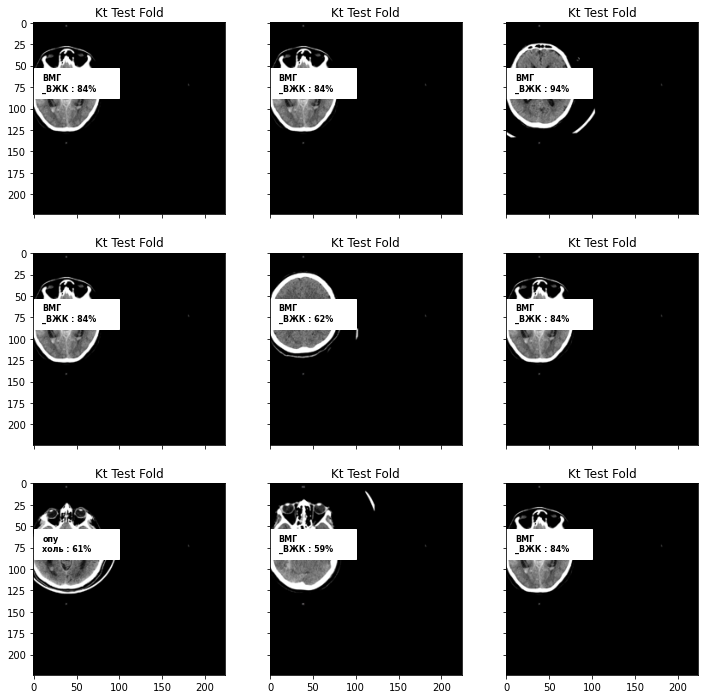

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
TEST_DIR = Path('/content/gdrive/MyDrive/kt_test_fold')

test_files = list(TEST_DIR.rglob("*.jpg"))

In [ ]:
test_dataset = KTDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(base_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

In [ ]:
print(preds)

['ВМГ_ВЖК' 'опухоль' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ_ВЖК' 'ВМГ 2'
 'ишемия' 'ВМГ_ВЖК' 'ВМГ_ВЖК']


In [ ]:
TRAIN_DIR = Path('train/Готовые снимки')
# TEST_DIR = Path('test/kt_test_data_test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
random.shuffle(train_val_files)
print(train_val_files)
# test_files = sorted(list(TEST_DIR.rglob('*.jpg')))